In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Note: This script was run on kaggle. Hence the need for all these initial steps**

In [2]:
#Setup Gdrive file download extention 
!conda install -y gdown

Retrieving notices: ...working... done
Channels:
 - rapidsai
 - nvidia
 - conda-forge
 - defaults
 - pytorch
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-24.7.1               |  py310hff52083_0         940 KB  conda-forge
    filelock-3.15.4            |     pyhd8ed1ab_0          17 KB  conda-forge
    gdown-5.2.0                |     pyhd8ed1ab_0          21 KB  conda-forge
    openssl-3.3.1              |       hb9d3cd8_3         2.8 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.7 MB

The following NEW packages will be INSTALLED:

  filelock           conda-forge/noarch::filelock-3.15.4-pyhd8ed1ab_0 
  gdown              conda-forge/noarch::gdow

In [3]:
#https://drive.google.com/file/d/1XI9ryAvJ6DNmNHeqGmpeUtKK1_drZ8im/view?usp=sharing
!gdown --id 1XI9ryAvJ6DNmNHeqGmpeUtKK1_drZ8im

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1XI9ryAvJ6DNmNHeqGmpeUtKK1_drZ8im
From (redirected): https://drive.google.com/uc?id=1XI9ryAvJ6DNmNHeqGmpeUtKK1_drZ8im&confirm=t&uuid=8e2d8622-36ce-4ab8-a8d2-2a87121a33f9
To: /kaggle/working/Gorilla Project.zip
100%|████████████████████████████████████████| 350M/350M [00:06<00:00, 53.5MB/s]


In [4]:
import zipfile

zip_file_path = '/kaggle/working/Gorilla Project.zip'  # replace with the name of your downloaded zip file
extract_path = '/kaggle/working/unzipped_folder'  # replace with your desired extract path

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to {extract_path}")

Files extracted to /kaggle/working/unzipped_folder


**The main code starts here**

In [5]:
import numpy as np
import librosa
import os
import soundfile as sf
import matplotlib.pyplot as plt

In [6]:
def extract_gorilla_segments_from_excel(excel_file_path, audio_files_dir, segment_length=None, delimiter=','):
    # Load Excel file
    excel_data = pd.ExcelFile(excel_file_path)

    # Initialize dictionaries to store segments and labels
    segments_dict = {}
    labels_dict = {}
    max_segment_length = 0  # Initialize maximum segment length

    # Iterate over each sheet in the Excel file
    for sheet_name in excel_data.sheet_names:
        # Extract common part of the audio file name from sheet name
        common_part = sheet_name.split('_')[0]

        # Find audio file matching the common part
        audio_file_name = None
        for file_name in os.listdir(audio_files_dir):
            if common_part in file_name:
                audio_file_name = os.path.splitext(file_name)[0]
                break

        # Skip if corresponding audio file not found
        if audio_file_name is None:
            print(f"Audio file not found for sheet '{sheet_name}'. Skipping...")
            continue

        # Load audio
        audio_file_path = os.path.join(audio_files_dir, f"{audio_file_name}.wav")
        y, sr = librosa.load(audio_file_path, sr=None, mono=True)

        # Read selection table from current sheet
        selection_table = excel_data.parse(sheet_name)

        # Initialize lists to store segments and labels
        segments = []
        labels = []

        # Iterate over rows in the selection table
        for index, row in selection_table.iterrows():
            # Extract relevant information
            begin_time = row['Begin Time (s)']
            end_time = row['End Time (s)']
            label = row['Gorilla Sound']

            # Convert time to samples
            begin_sample = int(begin_time * sr)
            end_sample = int(end_time * sr)

            # Determine segment length
            if segment_length is None:
                segment_length = end_sample - begin_sample
            else:
                max_segment_length = max(max_segment_length, end_sample - begin_sample)  # Update max segment length

            # Extract segment and pad or truncate to segment_length
            segment = y[begin_sample:end_sample]
            padded_segment = np.zeros(segment_length)
            padded_segment[:min(len(segment), segment_length)] = segment[:min(len(segment), segment_length)]

            # Append padded segment and label to lists
            segments.append(padded_segment)
            labels.append(label)

        # Store segments and labels in dictionaries
        segments_dict[audio_file_name] = segments
        labels_dict[audio_file_name] = labels

    return segments_dict, labels_dict, max_segment_length

In [7]:
# Example usage
excel_file_path = '/kaggle/working/unzipped_folder/input_dir/Selections/GORILLA SELECTIONSS.xlsx'
audio_files_dir = '/kaggle/working/unzipped_folder/input_dir/Gorilla Sounds'
segments_dict, labels_dict, max_segment_length = extract_gorilla_segments_from_excel(excel_file_path, audio_files_dir)

# Print the maximum segment length
print("Maximum segment length:", max_segment_length)

Maximum segment length: 281092


In [8]:
# Function to pad or truncate a segment
def pad_or_truncate(segment, target_length):
    if len(segment) > target_length:
        return segment[:target_length]
    else:
        return np.pad(segment, (0, target_length - len(segment)), 'constant')

# Determine the target length (maximum length of all segments)
max_length = max(max(len(segment) for segment in segments) for segments in segments_dict.values())

# Pad or truncate all segments to the target length
padded_segments_dict = {}
for audio_file_name, segments in segments_dict.items():
    padded_segments = [pad_or_truncate(segment, max_length) for segment in segments]
    padded_segments_dict[audio_file_name] = np.array(padded_segments)

# Convert segments and labels to arrays
all_segments = np.concatenate(list(padded_segments_dict.values()), axis=0)
all_labels = np.concatenate(list(labels_dict.values()), axis=0)

# Check the shapes of the resulting arrays
print("Shape of all_segments:", all_segments.shape)
print("Shape of all_labels:", all_labels.shape)

# Now all_segments and all_labels can be used for building a CNN model

Shape of all_segments: (323, 17061)
Shape of all_labels: (323,)


In [9]:
#segments_dict

To visualize the segments extracted from the audio file, the following steps are undertaken:

1. **Selecting an Audio File:**
   We specify the name of the audio file we want to visualize by assigning it to the variable `audio_file_name`.

2. **Getting Segments and Labels:**
   Using the previously extracted `segments_dict` and `labels_dict`, we retrieve the segments and their corresponding labels for the selected audio file.

3. **Plotting Segments:**
   For each segment, we plot its waveform along with its label. This is done by creating subplots for each segment using `plt.subplots`. The number of subplots corresponds to the number of segments extracted. We iterate through each segment, plot its waveform using `axs[i].plot(segment)`, and set titles indicating the segment number and its label. Axes labels are also set for clarity.

4. **Displaying the Plot:**
   Finally, we display the plot containing all the segments using `plt.show()`.

### Inputs:
- `audio_file_name`: Name of the audio file to visualize. Change this to the desired audio file name.
- `segments_dict`: Dictionary containing segments extracted from audio files.
- `labels_dict`: Dictionary containing labels corresponding to the extracted segments.


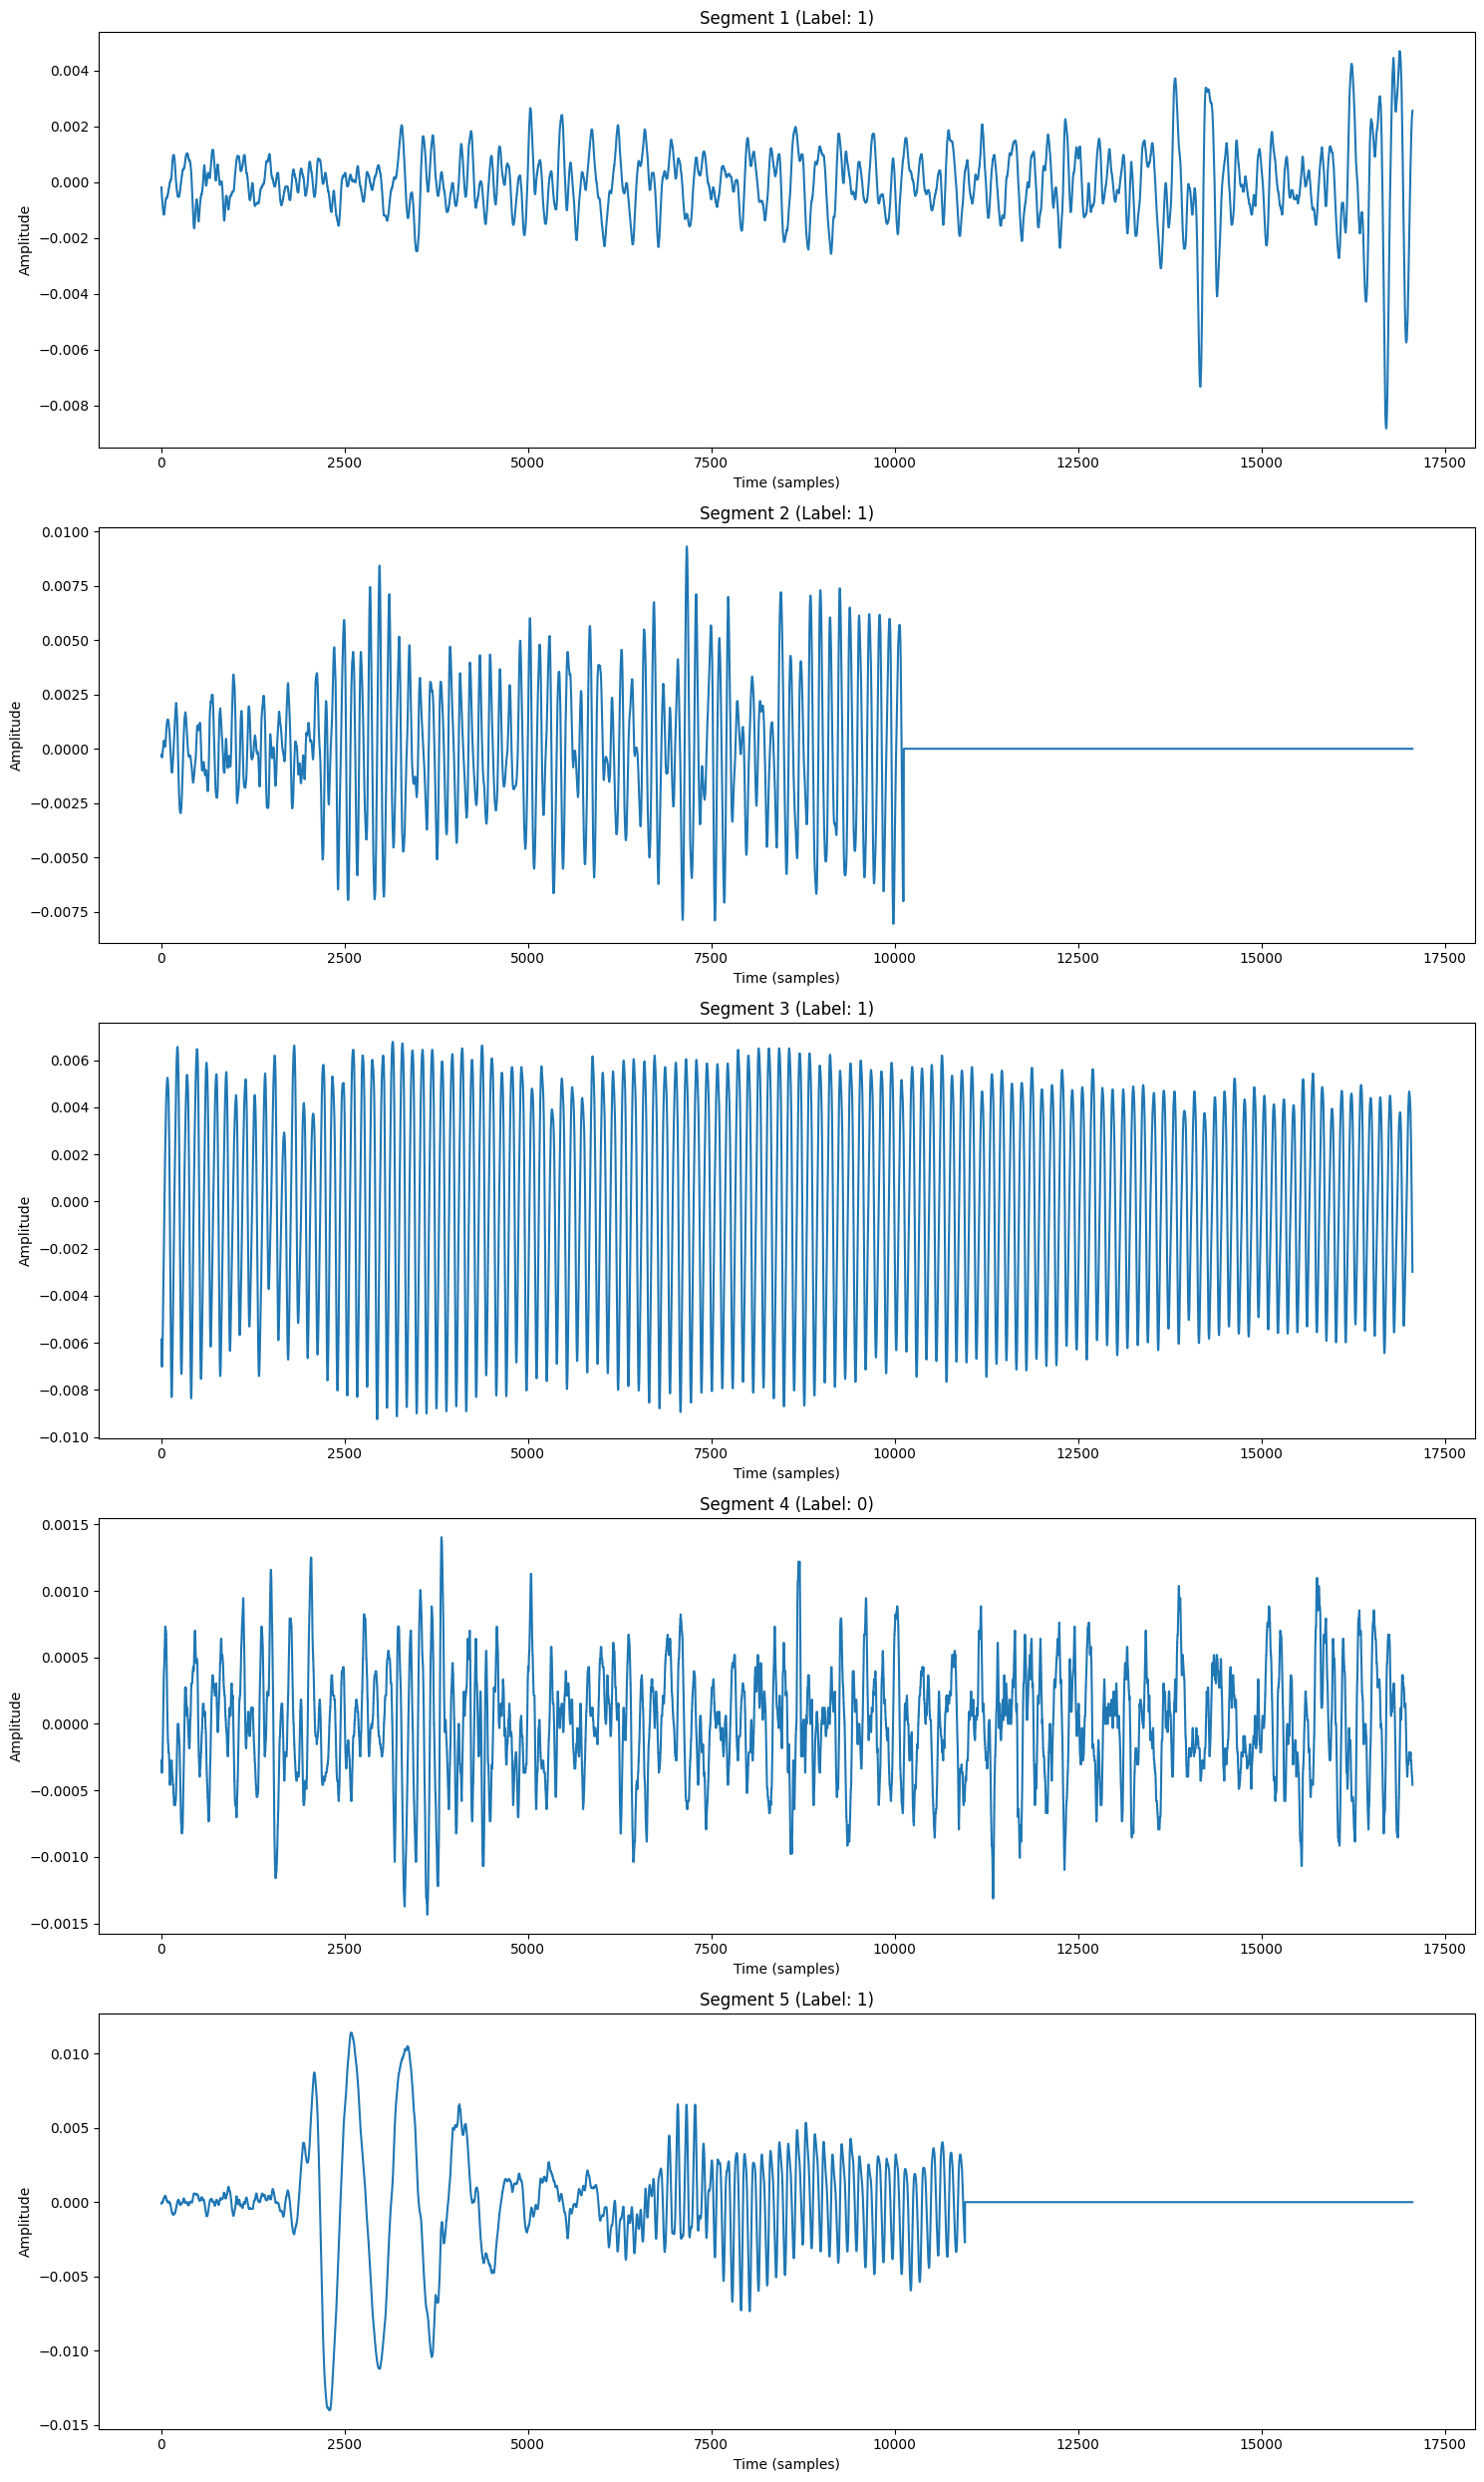

In [10]:
# Select an audio file to visualize
audio_file_name = '127_Kingo_Coco_7.wav_transposed_+12_ReaEQ'  # Change this to the desired audio file name

# Get segments and labels for the selected audio file
segments = segments_dict.get(audio_file_name, [])
labels = labels_dict.get(audio_file_name, [])

# Plot each segment along with its label
num_segments = len(segments)
fig, axs = plt.subplots(num_segments, 1, figsize=(15, 5*num_segments))
for i, (segment, label) in enumerate(zip(segments, labels)):
    axs[i].plot(segment)
    axs[i].set_title(f"Segment {i+1} (Label: {label})")
    axs[i].set_xlabel("Time (samples)")
    axs[i].set_ylabel("Amplitude")
plt.tight_layout()
plt.show()

In [10]:
def save_segments_and_labels_as_numpy(segments_dict, labels_dict, output_dir):
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Save segments_dict as NumPy arrays
    for audio_file_name, segments in segments_dict.items():
        segments_file_path = os.path.join(output_dir, f'{audio_file_name}_segments.npy')
        np.save(segments_file_path, segments)

    # Save labels_dict as NumPy arrays
    for audio_file_name, labels in labels_dict.items():
        labels_file_path = os.path.join(output_dir, f'{audio_file_name}_labels.npy')
        np.save(labels_file_path, labels)

# Usage
output_dir = '/kaggle/working/unzipped_folder/output_dir'
save_segments_and_labels_as_numpy(segments_dict, labels_dict, output_dir)

## Function to Load Segments and Labels from NumPy Arrays

This function `load_segments_and_labels_from_numpy()` loads gorilla vocalization segments and their corresponding labels from NumPy arrays stored in the specified output directory.

### Parameters:

- `output_dir`: Path to the directory containing the NumPy arrays of segments and labels.

### Functionality:

1. **Initialization:**
   - The function initializes empty dictionaries `segments_dict` and `labels_dict` to store loaded segments and labels, respectively.

2. **Iterating Over Files:**
   - It iterates over each file in the output directory using `os.listdir(output_dir)`.

3. **Loading Segments:**
   - If a file ends with '_segments.npy', it extracts the audio file name from the file name and constructs the file path for loading segments.
   - It loads the segments using `np.load()` with the `allow_pickle=True` argument to handle pickled objects.
   - The loaded segments are stored in `segments_dict` with the audio file name as the key.

4. **Loading Labels:**
   - If a file ends with '_labels.npy', it follows a similar process to load labels and store them in `labels_dict`.

### Returns:

- `segments_dict`: A dictionary containing loaded segments, where keys are audio file names and values are arrays of segments.
- `labels_dict`: A dictionary containing corresponding loaded labels for the segments.


In [11]:
def load_segments_and_labels_from_numpy(output_dir):
    segments_dict = {}
    labels_dict = {}

    # Iterate over files in the output directory
    for file_name in os.listdir(output_dir):
        # Check if file is a segments file
        if file_name.endswith('_segments.npy'):
            audio_file_name = file_name.split('_segments.npy')[0]
            segments_file_path = os.path.join(output_dir, file_name)
            segments = np.load(segments_file_path, allow_pickle=True)
            segments_dict[audio_file_name] = segments

        # Check if file is a labels file
        elif file_name.endswith('_labels.npy'):
            audio_file_name = file_name.split('_labels.npy')[0]
            labels_file_path = os.path.join(output_dir, file_name)
            labels = np.load(labels_file_path, allow_pickle=True)
            labels_dict[audio_file_name] = labels

    return segments_dict, labels_dict

# Usage
output_dir = '/kaggle/working/unzipped_folder/output_dir'
segments_dict, labels_dict = load_segments_and_labels_from_numpy(output_dir)

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

2024-08-26 19:58:02.192441: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-26 19:58:02.192543: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-26 19:58:02.324259: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [12]:
# Function to pad or truncate a segment
def pad_or_truncate(segment, target_length):
    if len(segment) > target_length:
        return segment[:target_length]
    else:
        return np.pad(segment, (0, target_length - len(segment)), 'constant')

# Determine the target length (maximum length of all segments)
max_length = max(max(len(segment) for segment in segments) for segments in segments_dict.values())

# Pad or truncate all segments to the target length
padded_segments_dict = {}
for audio_file_name, segments in segments_dict.items():
    padded_segments = [pad_or_truncate(segment, max_length) for segment in segments]
    padded_segments_dict[audio_file_name] = np.array(padded_segments)

# Convert segments and labels to arrays
all_segments = np.concatenate(list(padded_segments_dict.values()), axis=0)
all_labels = np.concatenate(list(labels_dict.values()), axis=0)

# Check the shapes of the resulting arrays
print("Shape of all_segments:", all_segments.shape)
print("Shape of all_labels:", all_labels.shape)

# Now all_segments and all_labels can be used for building a CNN model


Shape of all_segments: (323, 17061)
Shape of all_labels: (323,)


Count of 0s: 120
Count of 1s: 203


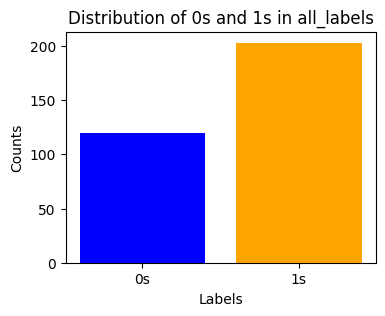

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Calculate the distribution of 0s and 1s
label_counts = Counter(all_labels)
count_zeros = label_counts[0]
count_ones = label_counts[1]

print(f"Count of 0s: {count_zeros}")
print(f"Count of 1s: {count_ones}")

# Plotting the distribution
labels = ['0s', '1s']
counts = [count_zeros, count_ones]

plt.figure(figsize=(4, 3))
plt.bar(labels, counts, color=['blue', 'orange'])
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Distribution of 0s and 1s in all_labels')
plt.show()


In [17]:
# Pad or truncate sequences to match the desired length (104240)
desired_length = 17061
padded_segments = []
for sequence in all_segments:
    if len(sequence) < desired_length:
        # Pad the sequence with zeros at the end
        padded_sequence = np.pad(sequence, (0, desired_length - len(sequence)), mode='constant')
    elif len(sequence) > desired_length:
        # Truncate the sequence from the end
        padded_sequence = sequence[:desired_length]
    else:
        # Sequence length matches the desired length
        padded_sequence = sequence
    padded_segments.append(padded_sequence)

# Convert the list of padded sequences back to numpy array
padded_segments = np.array(padded_segments)

# Verify the shape of the padded data
print("Shape of padded_segments:", padded_segments.shape)

Shape of padded_segments: (323, 17061)


In [18]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau


# Normalize the data
reshaped_segments = padded_segments.reshape(-1, desired_length)
scaler = StandardScaler()
# normalized_segments = scaler.fit_transform(reshaped_segments)
# normalized_segments = normalized_segments.reshape(-1, desired_length, 1)

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(reshaped_segments, all_labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

# Print the shapes of the training and testing sets
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Testing set:", X_test.shape, y_test.shape)


Training set: (258, 17061) (258,)
Validation set: (52, 17061) (52,)
Testing set: (13, 17061) (13,)


In [21]:
import tensorflow as tf
from tensorflow.keras import layers, models

def wave_unet(input_shape):  # Adjust input_shape based on your data
    inputs = layers.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv1D(64, 16, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv1D(64, 16, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling1D(pool_size=2)(conv1)

    conv2 = layers.Conv1D(128, 16, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv1D(128, 16, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling1D(pool_size=2)(conv2)

    conv3 = layers.Conv1D(256, 16, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv1D(256, 16, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling1D(pool_size=2)(conv3)

    # Bottleneck
    conv4 = layers.Conv1D(512, 16, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv1D(512, 16, activation='relu', padding='same')(conv4)

    # Decoder
    up5 = layers.Conv1DTranspose(256, 16, strides=2, padding='same')(conv4)
    if up5.shape[1] > conv3.shape[1]:
        up5 = layers.Cropping1D(cropping=((0, up5.shape[1] - conv3.shape[1])))(up5)
    elif up5.shape[1] < conv3.shape[1]:
        up5 = layers.ZeroPadding1D(padding=(0, conv3.shape[1] - up5.shape[1]))(up5)
    up5 = layers.concatenate([up5, conv3], axis=-1)
    conv5 = layers.Conv1D(256, 16, activation='relu', padding='same')(up5)
    conv5 = layers.Conv1D(256, 16, activation='relu', padding='same')(conv5)

    up6 = layers.Conv1DTranspose(128, 16, strides=2, padding='same')(conv5)
    if up6.shape[1] > conv2.shape[1]:
        up6 = layers.Cropping1D(cropping=((0, up6.shape[1] - conv2.shape[1])))(up6)
    elif up6.shape[1] < conv2.shape[1]:
        up6 = layers.ZeroPadding1D(padding=(0, conv2.shape[1] - up6.shape[1]))(up6)
    up6 = layers.concatenate([up6, conv2], axis=-1)
    conv6 = layers.Conv1D(128, 16, activation='relu', padding='same')(up6)
    conv6 = layers.Conv1D(128, 16, activation='relu', padding='same')(conv6)

    up7 = layers.Conv1DTranspose(64, 16, strides=2, padding='same')(conv6)
    if up7.shape[1] > conv1.shape[1]:
        up7 = layers.Cropping1D(cropping=((0, up7.shape[1] - conv1.shape[1])))(up7)
    elif up7.shape[1] < conv1.shape[1]:
        up7 = layers.ZeroPadding1D(padding=(0, conv1.shape[1] - up7.shape[1]))(up7)
    up7 = layers.concatenate([up7, conv1], axis=-1)
    conv7 = layers.Conv1D(64, 16, activation='relu', padding='same')(up7)
    conv7 = layers.Conv1D(64, 16, activation='relu', padding='same')(conv7)

    # Single output per time series
    outputs = layers.GlobalAveragePooling1D()(conv7)
    outputs = layers.Dense(1, activation='sigmoid')(outputs)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

input_shape = (desired_length, 1)
# Wave-Unet function 
model = wave_unet(input_shape)

# Compile the model
model.compile(
    optimizer='adam',                      # Optimizer
    loss='binary_crossentropy',           # Loss function
    metrics=['accuracy']                  # Metrics to track
)

# Print model summary to verify
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 17061, 1)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 17061, 64) │      1,088 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 17061, 64) │     65,600 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 8530, 64)  │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 8530, 128) │    131,200 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 8530, 128) │    262,272 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 4265, 128) │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 4265, 256) │    524,544 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 4265, 256) │  1,048,832 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 2132, 256) │          0 │ conv1d_5[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 2132, 512) │  2,097,664 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 2132, 512) │  4,194,816 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_transpose    │ (None, 4264, 256) │  2,097,408 │ conv1d_7[0][0]    │
│ (Conv1DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding1d      │ (None, 4265, 256) │          0 │ conv1d_transpose… │
│ (ZeroPadding1D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 4265, 512) │          0 │ zero_padding1d[0… │
│ (Concatenate)       │                   │            │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 4265, 256) │  2,097,408 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 4265, 256) │  1,048,832 │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_transpose_1  │ (None, 8530, 128) │    524,416 │ conv1d_9[0][0]    │
│ (Conv1DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 8530, 256) │          0 │ conv1d_transpose… │
│ (Concatenate)       │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 8530, 128) │    524,416 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 15,208,705 (58.02 MB)

 Trainable params: 15,208,705 (58.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


I0000 00:00:1724702940.088345     315 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


17/17 ━━━━━━━━━━━━━━━━━━━━ 234s 4s/step - accuracy: 0.6170 - loss: 0.7162 - val_accuracy: 0.5962 - val_loss: 0.6827 - learning_rate: 0.0010
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6155 - loss: 0.6874 - val_accuracy: 0.5962 - val_loss: 0.6842 - learning_rate: 0.0010
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6393 - loss: 0.6886 - val_accuracy: 0.5962 - val_loss: 0.6746 - learning_rate: 0.0010
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6296 - loss: 0.7297 - val_accuracy: 0.5962 - val_loss: 0.6797 - learning_rate: 0.0010
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6621 - loss: 0.6666 - val_accuracy: 0.5962 - val_loss: 0.6776 - learning_rate: 0.0010
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6484 - loss: 0.6651 - val_accuracy: 0.5962 - val_loss: 0.6776 - learning_rate: 0.0010
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6286 - loss: 0.6668 - val_accuracy: 0.5962 - v

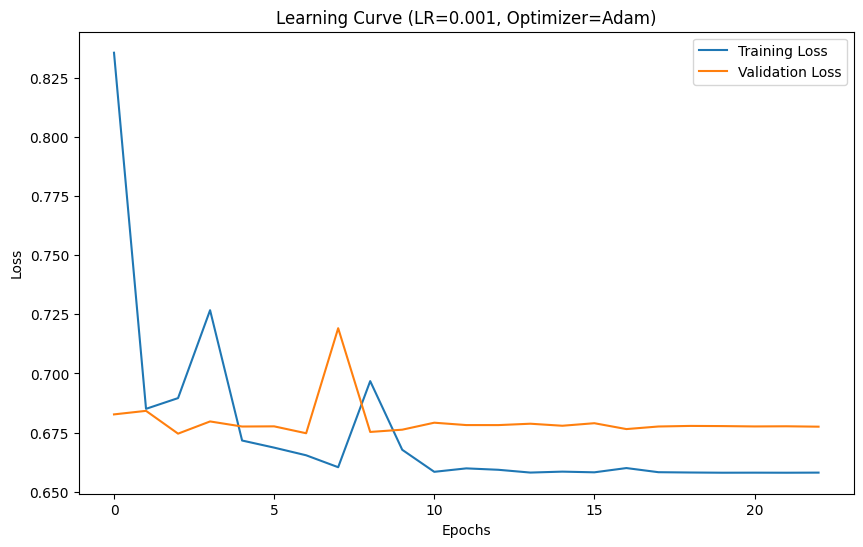

1/1 ━━━━━━━━━━━━━━━━━━━━ 56s 56s/step - accuracy: 0.6923 - loss: 0.6363
Learning Rate: 0.001, Optimizer: Adam, Test Loss: 0.6362857222557068, Test Accuracy: 0.692307710647583
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Accuracy: 0.6923076923076923
Precision: 0.6923076923076923
Recall: 1.0
F1 Score: 0.8181818181818181
Confusion Matrix:
[[0 4]
 [0 9]]
Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6333 - loss: 0.6597 - val_accuracy: 0.5962 - val_loss: 0.6746 - learning_rate: 1.6000e-06
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6014 - loss: 0.6724 - val_accuracy: 0.5962 - val_loss: 0.6746 - learning_rate: 1.6000e-06
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5915 - loss: 0.6764 - val_accuracy: 0.5962 - val_loss: 0.6746 - learning_rate: 1.6000e-06
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6108 - loss: 0.6685 - val_accuracy: 0.5962 - val_loss: 0.6746 - learning_rate: 1.6000e-06
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 19

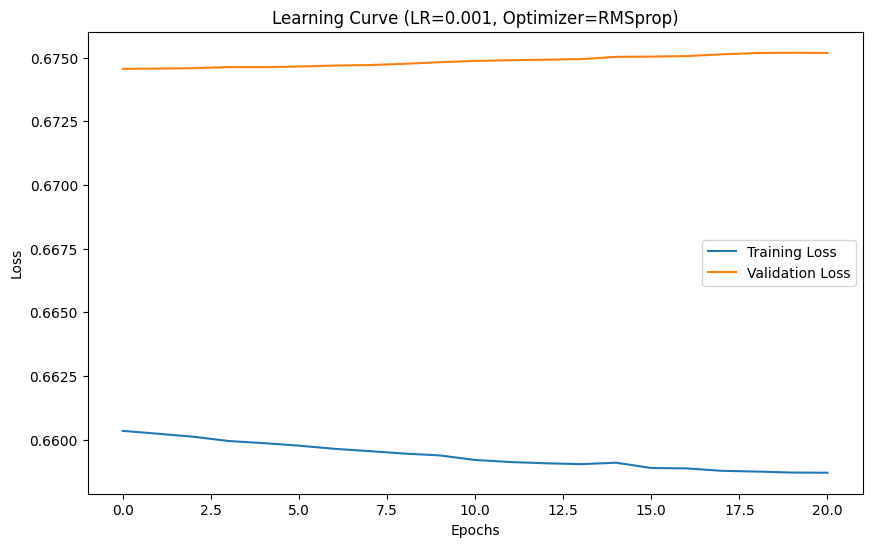

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.6923 - loss: 0.6360
Learning Rate: 0.001, Optimizer: RMSprop, Test Loss: 0.635982096195221, Test Accuracy: 0.692307710647583
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Accuracy: 0.6923076923076923
Precision: 0.6923076923076923
Recall: 1.0
F1 Score: 0.8181818181818181
Confusion Matrix:
[[0 4]
 [0 9]]
Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6276 - loss: 0.6619 - val_accuracy: 0.5962 - val_loss: 0.6746 - learning_rate: 1.0000e-06
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5998 - loss: 0.6731 - val_accuracy: 0.5962 - val_loss: 0.6746 - learning_rate: 1.0000e-06
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6327 - loss: 0.6598 - val_accuracy: 0.5962 - val_loss: 0.6746 - learning_rate: 1.0000e-06
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6237 - loss: 0.6634 - val_accuracy: 0.5962 - val_loss: 0.6746 - learning_rate: 1.0000e-06
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━

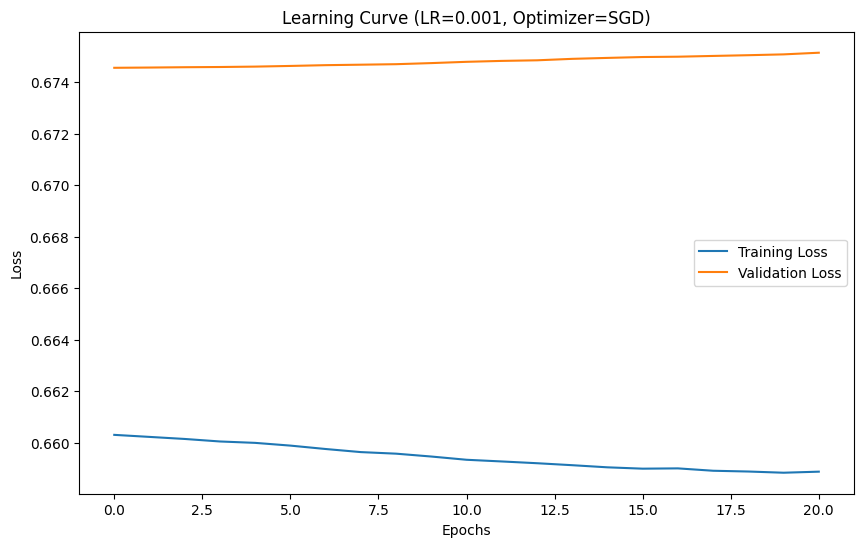

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.6923 - loss: 0.6361
Learning Rate: 0.001, Optimizer: SGD, Test Loss: 0.636090874671936, Test Accuracy: 0.692307710647583
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Accuracy: 0.6923076923076923
Precision: 0.6923076923076923
Recall: 1.0
F1 Score: 0.8181818181818181
Confusion Matrix:
[[0 4]
 [0 9]]
Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6234 - loss: 0.6636 - val_accuracy: 0.5962 - val_loss: 0.6746 - learning_rate: 1.0000e-06
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6517 - loss: 0.6522 - val_accuracy: 0.5962 - val_loss: 0.6746 - learning_rate: 1.0000e-06
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6329 - loss: 0.6597 - val_accuracy: 0.5962 - val_loss: 0.6746 - learning_rate: 1.0000e-06
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6674 - loss: 0.6455 - val_accuracy: 0.5962 - val_loss: 0.6746 - learning_rate: 1.0000e-06
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1

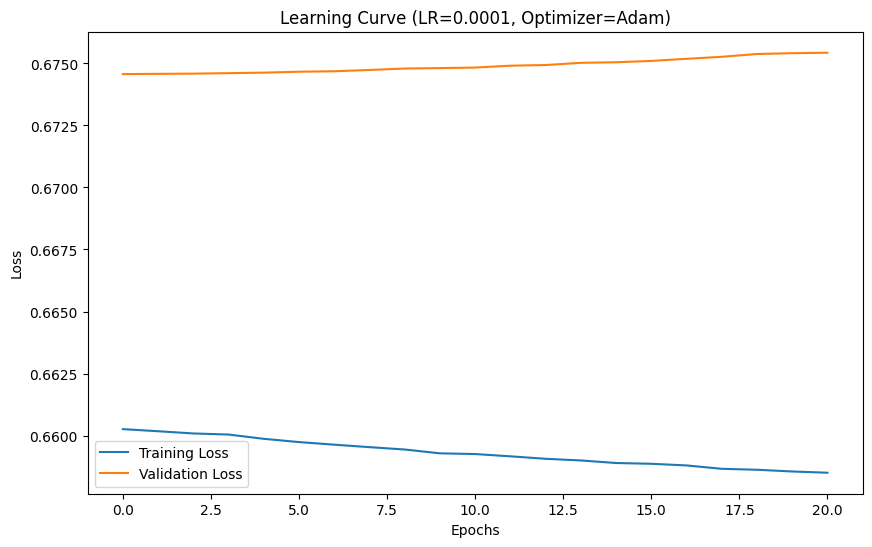

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.6923 - loss: 0.6358
Learning Rate: 0.0001, Optimizer: Adam, Test Loss: 0.6358168125152588, Test Accuracy: 0.692307710647583
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Accuracy: 0.6923076923076923
Precision: 0.6923076923076923
Recall: 1.0
F1 Score: 0.8181818181818181
Confusion Matrix:
[[0 4]
 [0 9]]
Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6314 - loss: 0.6604 - val_accuracy: 0.5962 - val_loss: 0.6746 - learning_rate: 1.0000e-06
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6074 - loss: 0.6700 - val_accuracy: 0.5962 - val_loss: 0.6746 - learning_rate: 1.0000e-06
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6035 - loss: 0.6716 - val_accuracy: 0.5962 - val_loss: 0.6746 - learning_rate: 1.0000e-06
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5895 - loss: 0.6773 - val_accuracy: 0.5962 - val_loss: 0.6746 - learning_rate: 1.0000e-06
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━

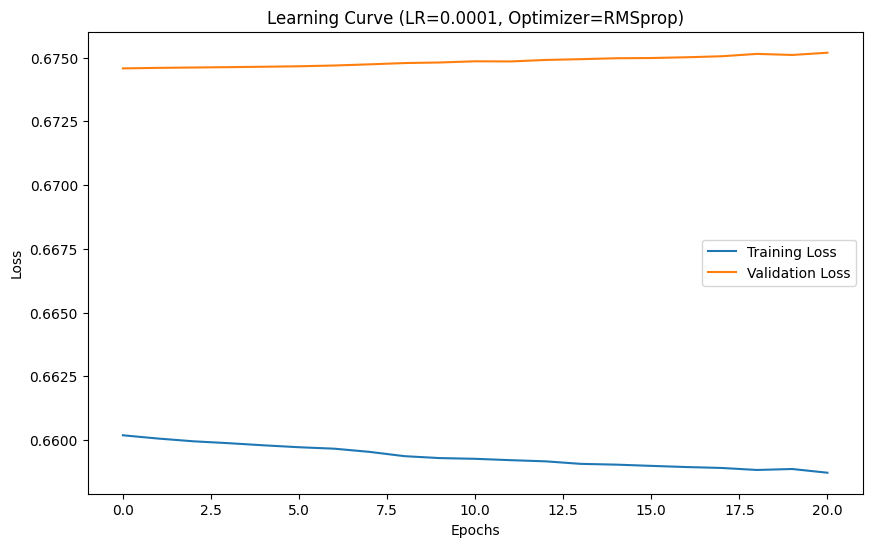

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.6923 - loss: 0.6356
Learning Rate: 0.0001, Optimizer: RMSprop, Test Loss: 0.635638952255249, Test Accuracy: 0.692307710647583
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Accuracy: 0.6923076923076923
Precision: 0.6923076923076923
Recall: 1.0
F1 Score: 0.8181818181818181
Confusion Matrix:
[[0 4]
 [0 9]]
Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6044 - loss: 0.6712 - val_accuracy: 0.5962 - val_loss: 0.6746 - learning_rate: 1.0000e-06
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6044 - loss: 0.6712 - val_accuracy: 0.5962 - val_loss: 0.6746 - learning_rate: 1.0000e-06
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6296 - loss: 0.6607 - val_accuracy: 0.5962 - val_loss: 0.6747 - learning_rate: 1.0000e-06
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6463 - loss: 0.6536 - val_accuracy: 0.5962 - val_loss: 0.6747 - learning_rate: 1.0000e-06
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━

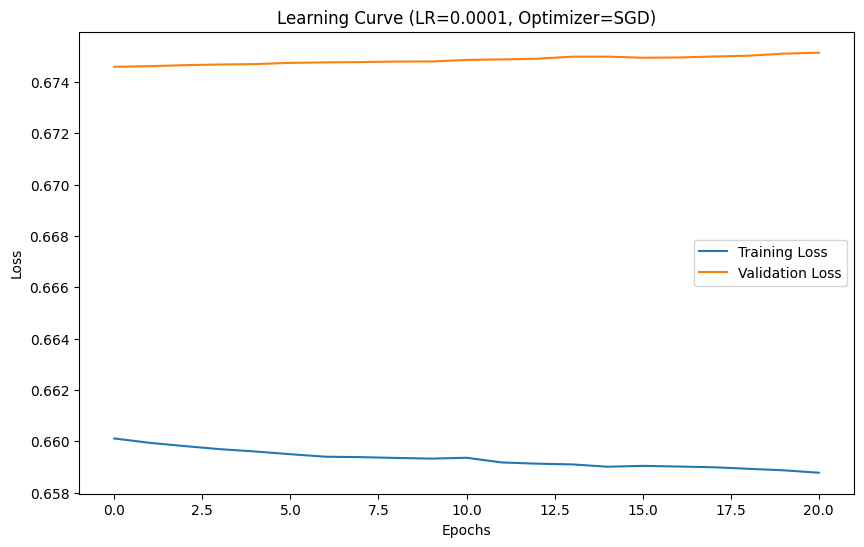

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.6923 - loss: 0.6354
Learning Rate: 0.0001, Optimizer: SGD, Test Loss: 0.6353709101676941, Test Accuracy: 0.692307710647583
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Accuracy: 0.6923076923076923
Precision: 0.6923076923076923
Recall: 1.0
F1 Score: 0.8181818181818181
Confusion Matrix:
[[0 4]
 [0 9]]
Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6398 - loss: 0.6567 - val_accuracy: 0.5962 - val_loss: 0.6746 - learning_rate: 1.0000e-06
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6436 - loss: 0.6550 - val_accuracy: 0.5962 - val_loss: 0.6746 - learning_rate: 1.0000e-06
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6504 - loss: 0.6520 - val_accuracy: 0.5962 - val_loss: 0.6747 - learning_rate: 1.0000e-06
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6126 - loss: 0.6677 - val_accuracy: 0.5962 - val_loss: 0.6747 - learning_rate: 1.0000e-06
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━

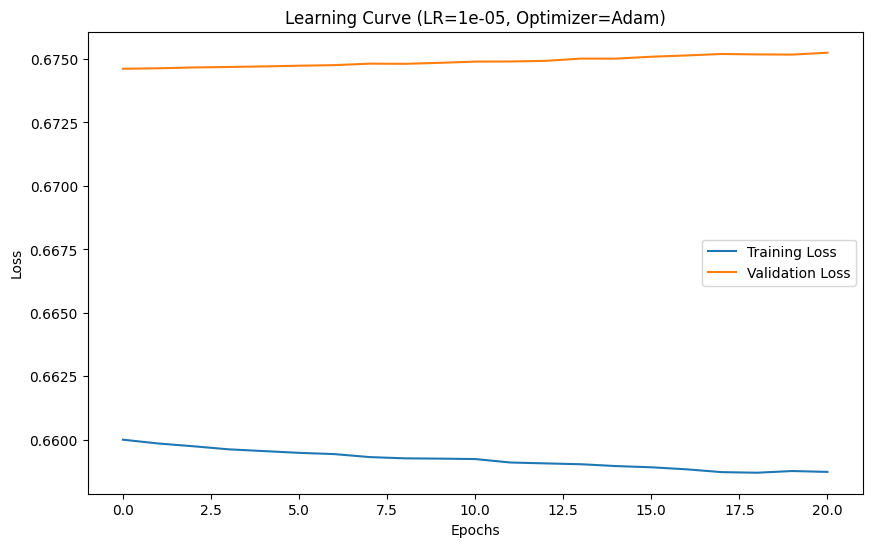

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.6923 - loss: 0.6349
Learning Rate: 1e-05, Optimizer: Adam, Test Loss: 0.6348637938499451, Test Accuracy: 0.692307710647583
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Accuracy: 0.6923076923076923
Precision: 0.6923076923076923
Recall: 1.0
F1 Score: 0.8181818181818181
Confusion Matrix:
[[0 4]
 [0 9]]
Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6086 - loss: 0.6695 - val_accuracy: 0.5962 - val_loss: 0.6746 - learning_rate: 1.0000e-06
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6709 - loss: 0.6436 - val_accuracy: 0.5962 - val_loss: 0.6746 - learning_rate: 1.0000e-06
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5938 - loss: 0.6757 - val_accuracy: 0.5962 - val_loss: 0.6747 - learning_rate: 1.0000e-06
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6007 - loss: 0.6727 - val_accuracy: 0.5962 - val_loss: 0.6747 - learning_rate: 1.0000e-06
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━

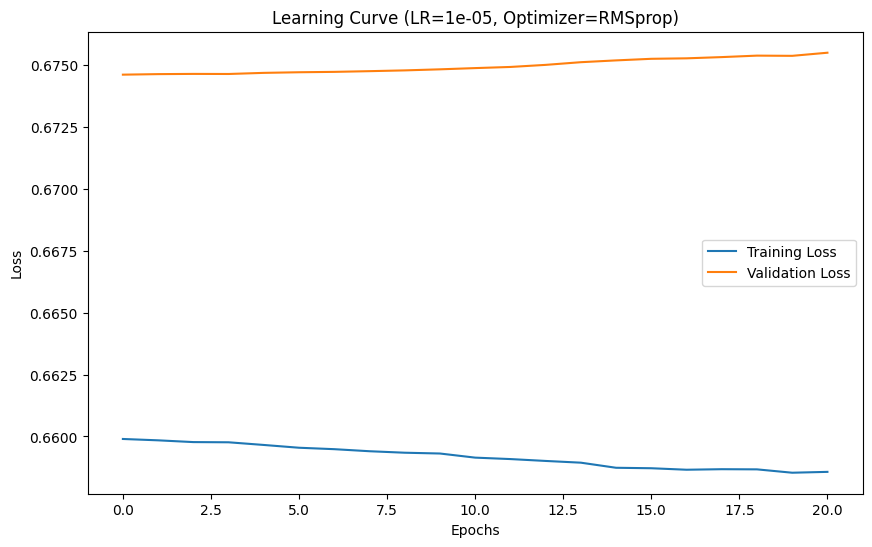

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.6923 - loss: 0.6347
Learning Rate: 1e-05, Optimizer: RMSprop, Test Loss: 0.6347388625144958, Test Accuracy: 0.692307710647583
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Accuracy: 0.6923076923076923
Precision: 0.6923076923076923
Recall: 1.0
F1 Score: 0.8181818181818181
Confusion Matrix:
[[0 4]
 [0 9]]
Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6543 - loss: 0.6505 - val_accuracy: 0.5962 - val_loss: 0.6746 - learning_rate: 1.0000e-06
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6307 - loss: 0.6602 - val_accuracy: 0.5962 - val_loss: 0.6746 - learning_rate: 1.0000e-06
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6287 - loss: 0.6610 - val_accuracy: 0.5962 - val_loss: 0.6747 - learning_rate: 1.0000e-06
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6632 - loss: 0.6465 - val_accuracy: 0.5962 - val_loss: 0.6747 - learning_rate: 1.0000e-06
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━

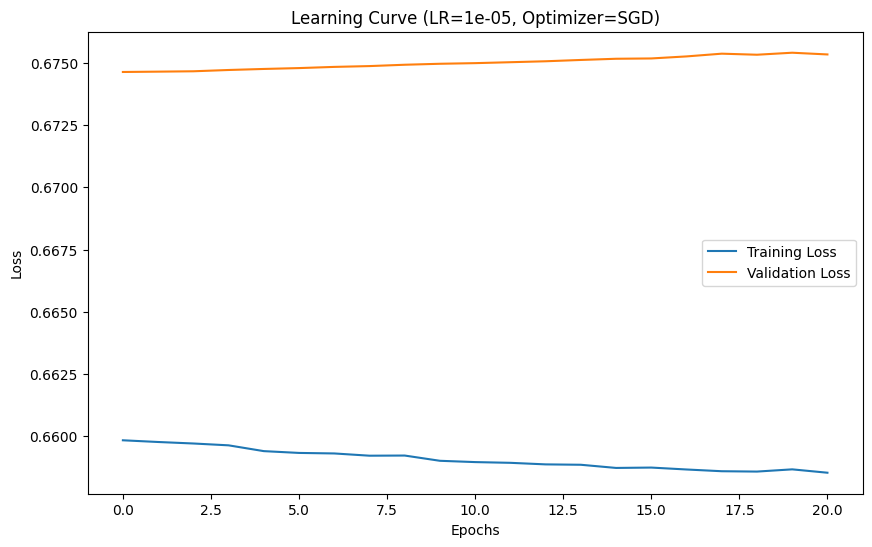

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.6923 - loss: 0.6346
Learning Rate: 1e-05, Optimizer: SGD, Test Loss: 0.6345717906951904, Test Accuracy: 0.692307710647583
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Accuracy: 0.6923076923076923
Precision: 0.6923076923076923
Recall: 1.0
F1 Score: 0.8181818181818181
Confusion Matrix:
[[0 4]
 [0 9]]
Learning Rate: 0.001, Optimizer: Adam, Test Loss: 0.6362857222557068, Test Accuracy: 0.692307710647583, Accuracy: 0.6923076923076923, Precision: 0.6923076923076923, Recall: 1.0, F1 Score: 0.8181818181818181
Confusion Matrix:
[[0 4]
 [0 9]]
Learning Rate: 0.001, Optimizer: RMSprop, Test Loss: 0.635982096195221, Test Accuracy: 0.692307710647583, Accuracy: 0.6923076923076923, Precision: 0.6923076923076923, Recall: 1.0, F1 Score: 0.8181818181818181
Confusion Matrix:
[[0 4]
 [0 9]]
Learning Rate: 0.001, Optimizer: SGD, Test Loss: 0.636090874671936, Test Accuracy: 0.692307710647583, Accuracy: 0.6923076923076923, Precision: 0.6923076923076923, Recall: 1

In [22]:
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


# Define the directory paths and callbacks
output_dir = 'output_dir'
model_logs_dir = os.path.join(output_dir, 'Model Logs Files')
visualization_dir = os.path.join(output_dir, 'Visualization')
os.makedirs(output_dir, exist_ok=True)
os.makedirs(model_logs_dir, exist_ok=True)
os.makedirs(visualization_dir, exist_ok=True)

checkpoint_filepath = os.path.join(output_dir, 'model_checkpoint.weights.h5')
csv_log_filepath = os.path.join(model_logs_dir, 'training_log.csv')
learning_curve_filepath = os.path.join(visualization_dir, 'learning_curve.png')

# Hyperparameters to test
learning_rates = [1e-3, 1e-4, 1e-5]
optimizers = [tf.keras.optimizers.Adam, tf.keras.optimizers.RMSprop, tf.keras.optimizers.SGD]

results = []

for lr in learning_rates:
    for optimizer_class in optimizers:
        optimizer = optimizer_class(learning_rate=lr)

        csv_logger_callback = CSVLogger(csv_log_filepath)
        model_checkpoint_callback = ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            save_best_only=True
        )
        early_stopping_callback = EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True
        )
        reduce_lr_callback = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-6
        )

        # Train the model
        history = model.fit(
            X_train, y_train,
            batch_size=16,
            epochs=50,
            validation_data=(X_val, y_val),
            callbacks=[model_checkpoint_callback, early_stopping_callback, csv_logger_callback, reduce_lr_callback]
        )

        # Plot and save learning curve
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Learning Curve (LR={lr}, Optimizer={optimizer_class.__name__})')
        plt.legend()
        plt.savefig(os.path.join(visualization_dir, f'learning_curve_lr{lr}_opt{optimizer_class.__name__}.png'))
        plt.show()

        # Evaluate the model on the testing set
        test_loss, test_accuracy = model.evaluate(X_test, y_test)
        print(f'Learning Rate: {lr}, Optimizer: {optimizer_class.__name__}, Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

        # Compute Metrics: Accuracy, Precision, Recall, F1-Score, Specificity
        y_pred_test = model.predict(X_test)
        y_pred_test_binary = (y_pred_test > 0.5).astype(int)

        accuracy = accuracy_score(y_test, y_pred_test_binary)
        precision = precision_score(y_test, y_pred_test_binary)
        recall = recall_score(y_test, y_pred_test_binary)
        f1 = f1_score(y_test, y_pred_test_binary)
        conf_matrix = confusion_matrix(y_test, y_pred_test_binary)

        print(f'Accuracy: {accuracy}')
        print(f'Precision: {precision}')
        print(f'Recall: {recall}')
        print(f'F1 Score: {f1}')
        print(f'Confusion Matrix:\n{conf_matrix}')

        results.append({
            'learning_rate': lr,
            'optimizer': optimizer_class.__name__,
            'test_loss': test_loss,
            'test_accuracy': test_accuracy,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'confusion_matrix': conf_matrix
        })

# Save the best trained model
model.save(os.path.join(output_dir, 'best_model.h5'))

# Print the results for comparison
for result in results:
    print(f"Learning Rate: {result['learning_rate']}, Optimizer: {result['optimizer']}, "
          f"Test Loss: {result['test_loss']}, Test Accuracy: {result['test_accuracy']}, "
          f"Accuracy: {result['accuracy']}, Precision: {result['precision']}, "
          f"Recall: {result['recall']}, F1 Score: {result['f1_score']}")
    print(f"Confusion Matrix:\n{result['confusion_matrix']}")